<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Clientes

## 1) Introdução

Neste trabalho iremos analisar a base de dados disponibilizada online pela Olist.

Esta base refere-se ao desenvolvimento do comércio eletrônico no Brasil nos últimos anos, apresentando informações tanto das compras realizadas, quanto dos clientes que as fizeram, dos vendedores envolvidos e dos produtos comercializado neste tempo.

Nosso objetivo é explorar esta base de dados para tirar informações relevantes para serem utilizadas nos negócios, culminando com uma segmentação dos clientes, onde estes possam ser classificados de acordo com sua assiduidade às compras online.

## 2) Preparação dos dados

In [1]:
! pip install squarify

In [2]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import squarify
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

fatal: destination path 'olist-e-commerce' already exists and is not an empty directory.


### 2.1) Gerando o dataframe

Para gerar um dataframe, iremos carregar os arquivos ***.csv*** de forma independente e depois iremos juntá-los uns aos outros através das chaves correspondentes.

In [4]:
# Carregando os datasets
customer = pd.read_csv('olist-e-commerce/datasets/olist_customers_dataset.csv')
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv')
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv')

In [5]:
# Junção dos dataframes
df = pd.merge(right=orders,
             left=customer,
             on='customer_id')

df = pd.merge(right=orders_items,
             left=df,
             on='order_id')

In [6]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [7]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')

Número de linhas: 112650 
Número de colunas: 18


### 2.2) Verificando a consistência dos dados

Para utilizar nosso dataframe da forma ideal, precisamos inicialmente ter certeza que os dados estão consistentes, ou seja, no formato ideal, que não há valores faltantes na tabela, etc. Checaremos essas condições a seguir.

In [8]:
# Convertendo a coluna "order_purchase_timestamp" para o formato datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [9]:
# Confirmando os tipos dos dados de cada coluna
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [10]:
# Verificando os valores nulos
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

## 3) Modelo RFM

O modelo RFM é largamente utilizado para segmentação de clientes, levando em consideração as respectivas características:

- ***Recência (Recency)***: total de dias em que o cliente não realiza uma compra.
- ***Frequência (Frequency)***: número total de compras que o cliente já realizou.
- ***Monetaridade (Monetary)***: gasto total do cliente.

Iremos então descobrir cada uma dessas variáveis a partir do dataframe obtido acima.

### 3.1) Selecionando as colunas

Aqui criaremos um dataframe levando em consideração algumas colunas específicas para utlizar o modelo RFM. Para isso, excluiremos algumas colunas do dataframe original, deixando apenas as features que são mais relevantes para cada caso. Chamaremos este dataframe de ***df_temp*** para indicar que este é um dataframe temporário e será alterado posteriormente.

In [11]:
df_temp = df.drop(columns=['customer_id', 'product_id',
                        'customer_zip_code_prefix', 'customer_city', 
                        'customer_state', 'order_status', 'order_approved_at', 
                        'order_delivered_carrier_date', 
                        'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_item_id', 
                        'seller_id', 'shipping_limit_date',
                        'freight_value'])
df_temp.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,230.00


- Data de Referência

Para calcularmos a recência, precisamos ter uma data de referência para podermos saber exatamente quantos dias cada cliente não realiza uma compra. Esta data será calculada a seguir.

In [12]:
# Criando uma data de referência
data_referencia = df_temp['order_purchase_timestamp'].max() + timedelta(days=1)
print(f'Data de referência: {data_referencia}')

Data de referência: 2018-09-04 09:06:57


Agora sim iremos adaptar as colunas de df_temp para nosso propósito.

In [13]:
df_temp = df_temp.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (data_referencia - x.max()).days,
    'order_id': 'count',    
    'price': 'sum'
}).reset_index()
df_temp.rename(columns={
    'order_id': 'frequency',
    'order_purchase_timestamp': 'recency',
    'price': 'monetary'
}, inplace=True)
df_temp.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [14]:
df_temp.isnull().sum()

customer_unique_id    0
recency               0
frequency             0
monetary              0
dtype: int64

Como agora, para essas colunas não há valores nulos podemos partir diretamente para a análise.

### 3.2) Definindo a quantidade ideal de grupos

Para atingirmos nosso objetivo, precisamos organizar os clientes com características semelhantes em grupos e classificá-los através de um label específico referente a tais grupos e para isso, precisamos encontrar o número ideal de agrupamentos de acordo com nossos dados. Portanto, para tal informação utilizaremos uma técnica denominada *Elbow Method*. 

Aplicaremos então o *Elbow Method* em dois casos possíveis: 
 - Nos dados originais do dataframe df_temp.
 - Com os respectivos dados devidamente escalonados.
 
Este teste visa compreender o comportamento dos dados em ambas as abordagens para definir se há uma diferença muito significativa entre uma ou outra.

#### 3.2.1) Valores originais

In [15]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters(df, column):
  """
  Função retorna a lista wcss com valores que definirão o número ideal de clusters.
  :param df: Dataframe que contém os respectivos dados.
  :param column: Coluna do dataframe a ser analisada.
  :return: Lista a ser usada no Elbow Method para determinar o número de clusters.
  """
  wcss = []
  X = df.iloc[:, [column]].values
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
  return wcss

In [16]:
wcss_r = define_clusters(df_temp, 1)
wcss_f = define_clusters(df_temp, 2)
wcss_m = define_clusters(df_temp, 3)

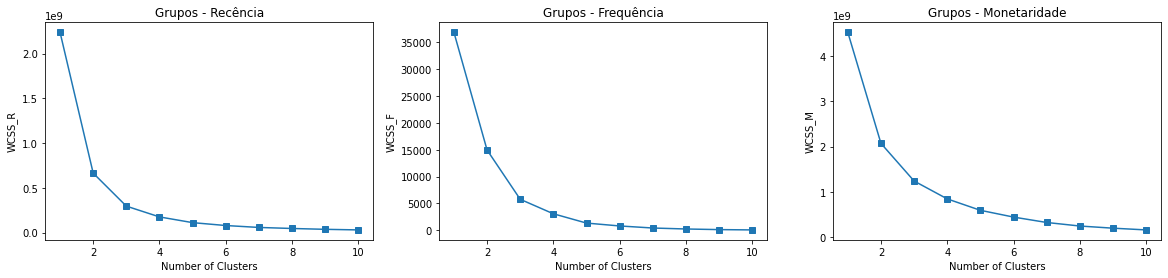

In [17]:
# Plotando os gráficos para cada dataframe
plt.figure(figsize=(20,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_r, marker='s')
plt.title('Grupos - Recência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_R')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_f, marker='s')
plt.title('Grupos - Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_F')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_m, marker='s')
plt.title('Grupos - Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_M')

plt.show()

#### 3.2.2) Valores escalonados

Iremos agora repetir o processo feito em (3.2.1) com os respectivos valores escalonados.

In [18]:
# Criando o scaler
scaler = StandardScaler()

In [19]:
# Separando as variáveis de df_temp para serem escalonadas

# Variável recency
X_R = df_temp.iloc[:, [1]].values

# Variável frequency
X_F = df_temp.iloc[:, [2]].values

# Variável monetary
X_M = df_temp.iloc[:, [3]].values

In [20]:
# Escalonando as variáveis X_R, X_F, X_M
X_RE = scaler.fit_transform(X_R)
X_FE = scaler.fit_transform(X_F)
X_ME = scaler.fit_transform(X_M)

In [21]:
# Utilizando o K-Means para definir o número de agrupamentos
def define_clusters_scaled(var):
   """
   Função retorna a lista wcss com valores que definirão o número ideal de clusters para colunas com valores escalonados.
   :param var: Série com os Valores escalonados.
   :return: Lista a ser usada no Elbow Method para determinar o número de clusters.
   """
   wcss = []
   for i in range(1, 11):
     kmeans = KMeans(n_clusters=i, random_state=0)
     kmeans.fit(var)
     wcss.append(kmeans.inertia_)
   return wcss

In [22]:
wcss_re = define_clusters_scaled(X_RE)
wcss_fe = define_clusters_scaled(X_FE)
wcss_me = define_clusters_scaled(X_ME)

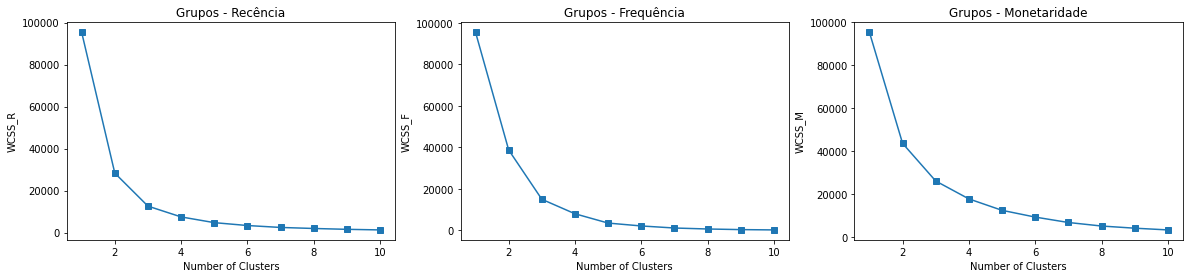

In [23]:
# Plotando os gráficos para as variáveis escalonadas
plt.figure(figsize=(20,4))

# Distribuição da recência
plt.subplot(1,3,1)
plt.plot(range(1, 11), wcss_re, marker='s')
plt.title('Grupos - Recência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_R')

# Distribuição da frequência
plt.subplot(1,3,2)
plt.plot(range(1, 11), wcss_fe, marker='s')
plt.title('Grupos - Frequência')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_F')

# Distribuição da monetaridade
plt.subplot(1,3,3)
plt.plot(range(1, 11), wcss_me, marker='s')
plt.title('Grupos - Monetaridade')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS_M')

plt.show()

Note que pelos gráficos obtidos na partes (3.3.1) e (3.3.2) obtivemos resultados similares, e portanto para este caso o escalonamento das variáveis é opcional, sendo então possível utilizar ambas as abordagens. Por isso, consideraremos cinco clusters como a quantidade ideal. 

### 3.3) Fazendo o treinamento via K-Means

Definido então a quantidade de 5 clusteres como o ideal, podemos fazer o treinamento dos dados da maneira como segue. Além disso, de acordo com o resultado obtido criaremos labels referentes a cada grupo.

In [24]:
# Considerando portanto 5 clusters
def cluster_clients(df, column):
  """
  Função que retorna as previsões dos labels de cada cluster encontrados pelo K-Means.
  :param df: Dataframe com os respectivos dados.
  :param column: Coluna do dataframe a ser analisada.
  :return: Retorna as previsões de label para cada cluster.
  """
  X = df.iloc[:, [column]].values
  kmeans = KMeans(n_clusters=5, random_state=0)
  previsoes = kmeans.fit_predict(X)
  return previsoes

In [25]:
# Criando os labels para cada dataframe
label_r = cluster_clients(df_temp, 1)
label_f = cluster_clients(df_temp, 2)
label_m = cluster_clients(df_temp, 3)

In [26]:
# Criação de uma coluna com os labels
df_temp['R'] = label_r
df_temp['F'] = label_f
df_temp['M'] = label_m

In [27]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 
                 'frequency', 'F', 
                 'monetary', 'M']

df_temp = df_temp.reindex(columns=columnsTitles)

In [28]:
df_temp.head()

,customer_unique_id,recency,R,frequency,F,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,0,1,0,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,0,1,0,18.90,0
2,0000f46a3911fa3c0805444483337064,542,1,1,0,69.00,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,4


### 3.4) Rearranjando os índices dos labels

Um importante ajuste que necessita-se fazer agora é redefinir os labels R, F, M para que eles possam associar a cada grupo um grau de importância, atribuindo-se assim um "peso" para cada cluster. Neste ponto, podemos utilizar a seguinte referência:

- Recência: quanto maior, pior. Ordem de importância: 4, 3, 2, 1, 0.
- Frequência: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.
- Monetaridade: quanto maior, melhor. Ordem de importância: 0, 1, 2, 3, 4.

In [29]:
df_temp.groupby('R').mean().sort_values(by='recency', ascending=False).reset_index()['R']

0    1
1    4
2    2
3    0
4    3
Name: R, dtype: int64

In [30]:
df_temp.groupby('F').mean().sort_values(by='recency', ascending=True).reset_index()['F']

0    4
1    3
2    1
3    2
4    0
Name: F, dtype: int64

In [31]:
df_temp.groupby('M').mean().sort_values(by='monetary', ascending=True).reset_index()['M']

0    0
1    4
2    1
3    3
4    2
Name: M, dtype: int64

Assim, os labels precisam ser alterados da forma:

- R: 0 -> 3; 1 -> 0; 2 -> 2; 3 -> 4; 4 -> 1.
- F: 0 -> 4; 1 -> 2; 2 -> 3; 3 -> 1; 4 -> 0.
- M: 0 -> 0; 1 -> 2; 2 -> 4; 3 -> 3; 4 -> 1.

Podemos realizar este ajusta mediante uma função.

In [32]:
def adjust_index(df, column, label, ascend):
  """
  Função que adiciona uma coluna com labels ajustados e retorna o novo dataframe.
  :param df: Dataframe que contém os respectivos dados.
  :param column: Coluna que será ordenada para ajuste dos labels.
  :param label: Coluna cujo label será ajustado.
  :param ascend: Forma de ordenar os dados. Se True ascendente; se False descendente.
  :return: Dataframe com a coluna com labels ajustados.
  """
  x = df.groupby(label).mean().sort_values(by=column, ascending=ascend).reset_index()
  index = tuple(zip(x.index, x[label].values))
  for c in index:
    df.loc[df[label] == c[1], f'adjusted_{label}'] = c[0] 
  df[f'adjusted_{label}'] = df[f'adjusted_{label}'].apply(lambda x: int(x))
  return df

In [33]:
df_temp = adjust_index(df_temp, 'recency', 'R', False)
df_temp = adjust_index(df_temp, 'frequency', 'F', True)
df_temp = adjust_index(df_temp, 'monetary', 'M', True)

In [34]:
# Alterando a ordem das colunas de forma apropriada
columnsTitles = ['customer_unique_id', 
                 'recency', 'R', 'adjusted_R' ,
                 'frequency', 'F', 'adjusted_F',
                 'monetary', 'M', 'adjusted_M']

df_temp = df_temp.reindex(columns=columnsTitles)

### 3.5) Criando o dataframe final

Podemos agora criar o dataframe final que irá exibir os clientes levando em consideração sua pontuação total (representada pela coluna score) e suas respectivas classificações (coluna RFM_level).

In [35]:
# Excluindo as colunas R, F, M e renomeando as colunas adjusted_R, adjusted_F, adjusted_M
df_final = df_temp.drop(columns=['R', 'F', 'M'])

In [36]:
# Renomeando as colunas
df_final.rename(columns={'adjusted_R': 'R',
                         'adjusted_F': 'F',
                         'adjusted_M': 'M'}, inplace=True)

In [37]:
# Criando uma coluna com a pontuação final de cada cliente
df_final['score'] = df_final['R'] + df_final['F'] + df_final['M']

Agora podemos classificar cada cliente utilizando o critério visto na função a seguir.

In [38]:
print(f'Score mínimo: {df_final["score"].min()} \nScore máximo: {df_final["score"].max()}')

Score mínimo: 0 
Score máximo: 12


In [39]:
def rfm_classification(df):
  """
  Função que retorna a classificação de cada cliente de acordo com seu score.
  :param df: Dataframe com a coluna do score dos clientes.
  :return: Retorna a classificação podendo ela ser Ruim, Regular, Bom, Muito bom e Ótimo.
  """
  if df['score'] <= 1:
    return 'Ruim'
  elif df['score'] <= 3:
    return 'Regular'
  elif df['score'] <= 4:
    return 'Bom'
  elif df['score'] <= 5:
    return 'Muito bom'
  else:
    return 'Ótimo'

In [40]:
# Criação de uma nova coluna RMF_leve
df_final['RFM_level'] = df_final.apply(rfm_classification, axis=1)
df_final.head()

,customer_unique_id,recency,R,frequency,F,monetary,M,score,RFM_level
0,0000366f3b9a7992bf8c76cfdf3221e2,116,3,1,0,129.90,0,3,Regular
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,3,1,0,18.90,0,3,Regular
2,0000f46a3911fa3c0805444483337064,542,0,1,0,69.00,0,0,Ruim
3,0000f6ccb0745a6a4b88665a16c9f078,326,2,1,0,25.99,0,2,Regular
4,0004aac84e0df4da2b147fca70cf8255,293,2,1,0,180.00,1,3,Regular


## 4) Agrupando os clientes

Agora podemos fazer um agrupamento dos clientes considerando as variáveis recência, frequência e monetaridade duas a duas, obtendo assim três gráficos relacionando os clientes a cada uma das variáveis.

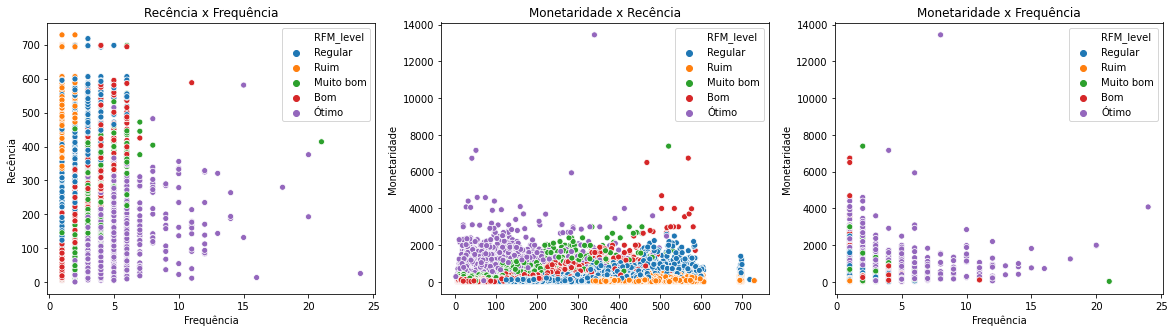

In [41]:
# Plotando os gráficos
plt.figure(figsize=(20,5))

# Recência x Frequência
plt.subplot(1,3,1)
sns.scatterplot(data=df_final, 
                x='frequency', 
                y='recency', 
                hue='RFM_level')
plt.title('Recência x Frequência')
plt.xlabel('Frequência')
plt.ylabel('Recência')

# Monetaridade x Recência
plt.subplot(1,3,2)
sns.scatterplot(data=df_final, 
                x='recency', 
                y='monetary', 
                hue='RFM_level')
plt.title('Monetaridade x Recência')
plt.xlabel('Recência')
plt.ylabel('Monetaridade')

# Monetaridade x Frequência
plt.subplot(1,3,3)
sns.scatterplot(data=df_final, 
                x='frequency', 
                y='monetary', 
                hue='RFM_level')
plt.title('Monetaridade x Frequência')
plt.xlabel('Frequência')
plt.ylabel('Monetaridade')

plt.show()

## 5) Agrupamento geral

Por fim, criaremos um diagrama com a quantidade de clientes em cada categoria. Este diagrama nos dará uma noção visual do quão grande é a discrepância de uma categoria para outra no que diz respeito a sua quantidade.

In [42]:
# Cálculo dos valores médios para RMF_level
rfm_level_agg = df_final.groupby('RFM_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
})

In [43]:
rfm_level_agg

recency frequency    monetary       
                 mean      mean        mean  count
RFM_level                                         
Bom        102.091160  1.167557  141.292152  21336
Muito bom  107.042935  1.576425  306.627126   6405
Regular    241.762893  1.090057  112.510560  43339
Ruim       452.596187  1.029444   85.577081  21193
Ótimo       98.788688  2.727359  611.171719   3147

In [44]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

###  5.1) Plotando o diagrama

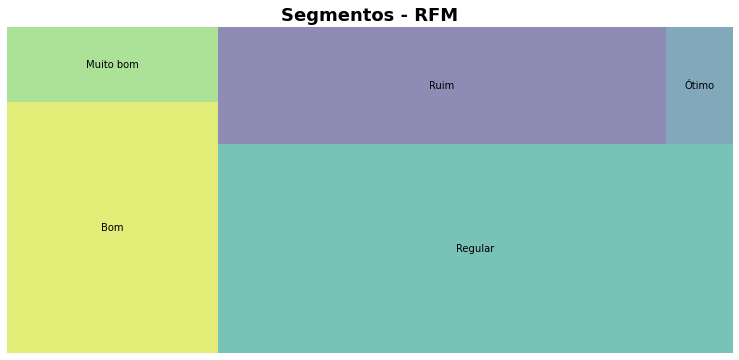

In [46]:
# Plotando o respectivo diagrama
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13,6)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Bom',
                     'Muito bom',
                     'Regular',
                     'Ruim',                                          
                     'Ótimo',
                     ], alpha=.6 )
plt.title("Segmentos - RFM",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()